# CAP 5610 Final Project

# <span style='color:#AF0000'> Sentiment Analysis of Covid Tweets </span>

![](https://omisido.com/wp-content/uploads/2014/06/twitter-now-supports-animated-gif.gif)

## <span style='color:blue'> Project Goal
    
The main goal of this project is to introduce a real-time system for sentiment analysis on Twitter data about the coronavirus pandemic. The projected system objects to find the optimal machine learning model that achieves the best performance for coronavirus sentiment analysis prediction and then use the predicted results in real-time which can help healthcare administrations, medical organization and society monitor current and future covid situation

## <span style='color:blue'> Libraries

In [2]:
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set(rc={'figure.figsize':(16,8)})
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
twitter_image = np.array(Image.open("twitter_mask.png"))

# Data processing
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import casual_tokenize
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

## <span style='color:blue'> Data
    
The twitter dataset used for sentiment analysis has tweets from varying location and dates. Two datasets divided as training dataset and testing dataset has been combined for the sentiment analysis. The dataset has a target feature ‘Sentiment’, which is tagged using 5 classes from ‘Highly Negative’ to ‘Highly Positive’. The target feature is then mapped to 3 target classes as ‘negative’, ’neutral’ and ‘positive’ for analysis.


In [4]:
# Import train and test tweets downloaded from kaggle
train_Tweets = pd.read_csv(r'Corona_NLP_train.csv', encoding='latin-1')
test_Tweets = pd.read_csv(r'Corona_NLP_test.csv')

# concatenate test and train tweets datasets to form single dataset
covidTweets = pd.concat([train_Tweets,test_Tweets])

In [5]:
covidTweets.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
print("Size of dataset:", covidTweets.shape)
print("Target classes:",covidTweets.Sentiment.unique())

Size of dataset: (44955, 6)
Target classes: ['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']


In [7]:
# Convert Sentiment classes (target) from 5 to 3
def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
covidTweets['Sentiment'] = covidTweets['Sentiment'].apply(lambda x:classes_def(x))

print("Converted Target classes:",covidTweets.Sentiment.unique())    

Converted Target classes: ['neutral' 'positive' 'negative']


In [8]:
# Copy the text in a new column to compare the processed tweets to the original tweets
covidTweets['tweet_text'] = covidTweets.OriginalTweet
covidTweets["tweet_text"] = covidTweets["tweet_text"].astype(str)

## <span style='color:blue'> Exploratory Data Analysis

### <span style = 'color:indigo'> 1) Tweets by date

In [9]:
# Group tweets by tweet date
covidTweets['TweetAt'] = pd.to_datetime(covidTweets['TweetAt']).dt.date
tweet_date = covidTweets['TweetAt'].value_counts().to_frame().reset_index().rename(columns = {'index':'Tweet Date','TweetAt':'count'})
tweet_date = tweet_date.sort_values('Tweet Date',ascending=False)

print("Tweet Date range is between %s to %s" %(tweet_date['Tweet Date'].min(), tweet_date['Tweet Date'].max()))
print("\nTop 5 dates with highest number of tweets per day")
tweet_date.sort_values('count',ascending=False).head(5)

Tweet Date range is between 2020-01-04 to 2020-12-04

Top 5 dates with highest number of tweets per day


,Tweet Date,count
0,2020-03-20,3448
1,2020-03-19,3215
2,2020-03-25,2979
3,2020-03-18,2742
4,2020-03-21,2653


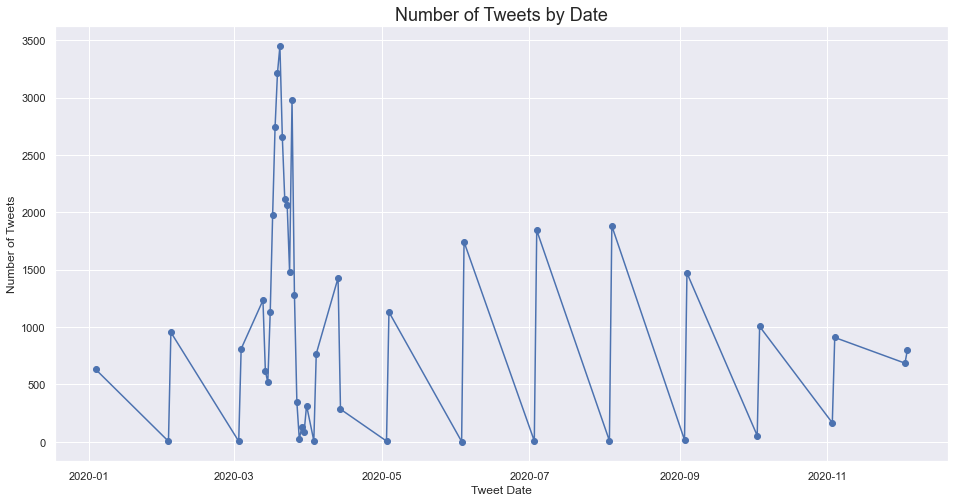

In [10]:
# Plot TweetsDate Vs Tweet Count
x = tweet_date['Tweet Date']
y = tweet_date['count']
plt.scatter(x, y, zorder=1)
plt.plot(x, y, zorder=2)
plt.xlabel("Tweet Date")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets by Date", fontsize = 18)
plt.show()

#### Tweet dates in the dataset ranges from 04 Jan 2020 to 04 Dec 2020.  Highest number of tweets per day was done on Mar 20th 2020

###  <span style = 'color:indigo'> 2) Tweets by Hashtag

In [11]:
def find_hash(text):
    line = re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
covidTweets['hash'] = covidTweets['tweet_text'].apply(lambda x:find_hash(x))

# Group tweets by hashtag
covidTweets['hash'] = covidTweets['tweet_text'].apply(lambda x:find_hash(x))
hashtags = covidTweets['hash'].value_counts()[:][1:11]
hashtags = hashtags.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'Number of Tweets'})

print("\nTop 10 hashtags used in covid tweets")
hashtags.sort_values('Number of Tweets',ascending=False).head(10)


Top 10 hashtags used in covid tweets


,Hashtag,Number of Tweets
0,coronavirus,2956
1,Covid_19,1157
2,Coronavirus,598
3,COVID2019,470
4,coronavirus COVID19,234
5,COVID19,231
6,COVID19 coronavirus,171
7,CoronaCrisis,167
8,CoronaVirus,148
9,SocialDistancing,105


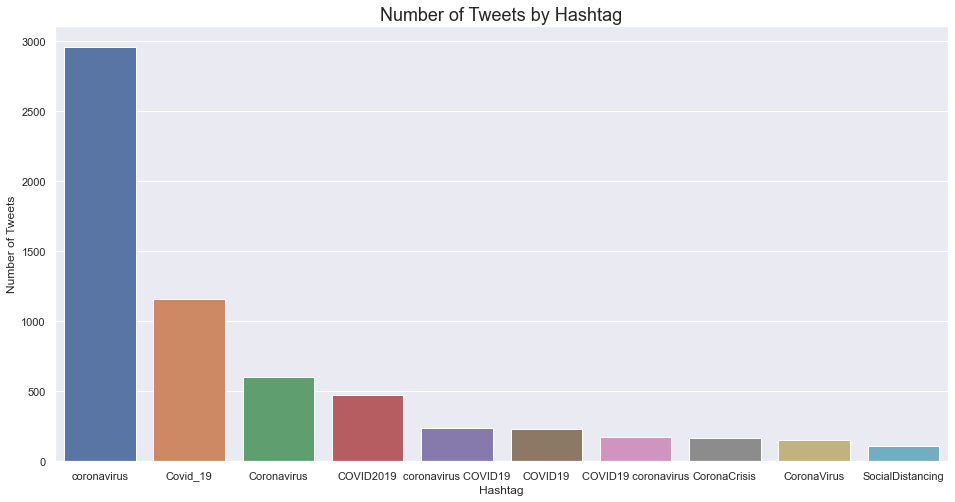

In [12]:
# Plot TweetsDate Vs Tweet Count
plt.title("Number of Tweets by Hashtag", fontsize = 18)
sns.color_palette("tab10")
sns.barplot(x = "Hashtag", y = "Number of Tweets", data = hashtags)

plt.show()

#### Bar plot shows the top 10 hashtags used for covid related tweets with #coronavirus being the most used.

###  <span style = 'color:indigo'> 3) Number of tweets by Sentiment Class

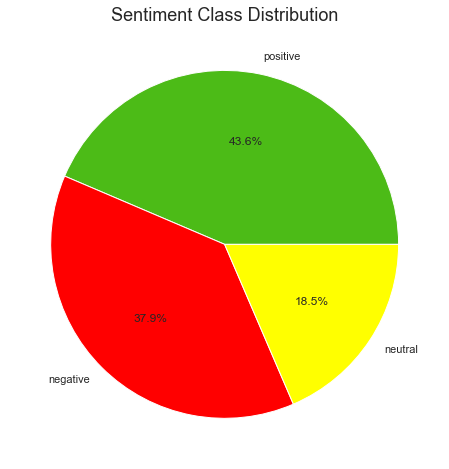

In [13]:
class_sentiment = covidTweets.groupby('Sentiment').count()['tweet_text'].reset_index().sort_values(by='tweet_text',ascending=False)
data = class_sentiment.tweet_text
mylabels = class_sentiment.Sentiment
mycolors = ['#4CBB17','#FF0000','#FFFF00']

plt.title("Sentiment Class Distribution", fontsize = 18)
plt.pie(data, labels=mylabels, colors = mycolors, autopct="%.1f%%")
plt.show() 

In [14]:
print("Number of tweets by sentiment class")
class_sentiment.style.background_gradient()

Number of tweets by sentiment class


,Sentiment,tweet_text
2,positive,19592
0,negative,17031
1,neutral,8332


#### The class distribution of tweets (target feature with 3 classes – positive, negative and neutral) shows that the dataset has an uneven class distribution with highest number of positive tweets followed by negative tweets and least number of neutral sentiment tweets.

### <span style = "color: indigo"> 4) Number of words in tweets

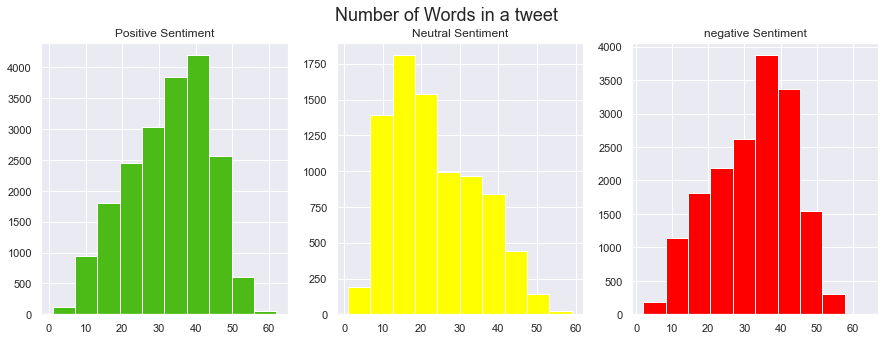

In [15]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

tweet_len_pos = covidTweets[covidTweets['Sentiment']=="positive"]['tweet_text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len_pos,color = '#4CBB17')
ax1.set_title('Positive Sentiment')

tweet_len_neu = covidTweets[covidTweets['Sentiment']=="neutral"]['tweet_text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len_neu,color = '#FFFF00')
ax2.set_title('Neutral Sentiment')

tweet_len_neg = covidTweets[covidTweets['Sentiment']=="negative"]['tweet_text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len_neg,color = '#FF0000')
ax3.set_title('negative Sentiment')

fig.suptitle('Number of Words in a tweet', fontsize = 18)
plt.show()

#### Historgrams show that the number words used in most postitive and negative tweets are comparitively more than the number of words in neutral tweets

### <span style = "color: indigo"> 5) Stop words

In [16]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stopwords = set(STOPWORDS) 

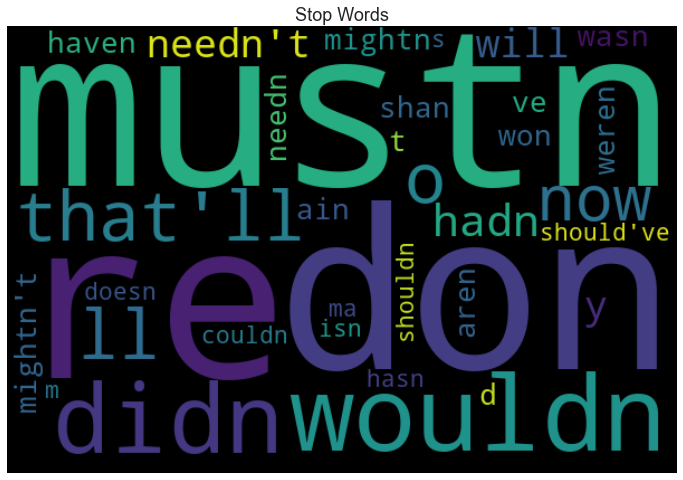

In [17]:
comment_words = '' 
for val in stop:
    val = str(val) 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    comment_words += " ".join(tokens)+" " 
    
wordcloud_stop = WordCloud(width = 600, height = 400, 
                background_color ='black',
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image     
fig, (ax) = plt.subplots(1,1,figsize=[12, 12])
ax.imshow(wordcloud_stop, interpolation = 'bilinear')
ax.axis('off')
ax.set_title('Stop Words' ,fontsize = 18)
plt.show()

#### Above wordcloud shows the most used stop words in the covid tweets text.

### <span style = "color : indigo" > 6) Most used words

In [18]:
def remove_tag(string):
    text = re.sub('<.*?>','',string)
    return text
def remove_mention(string):
    text = re.sub(r'@\w+','',string)
    return text
def remove_hash(string):
    text = re.sub(r'#\w+','',string)
    return text
def remove_newline(string):
    text = re.sub('\n','',string)
    return text
def remove_url(string): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',string)
    return text
def remove_number(string):
    text = re.sub(r'[0-9]+','',string)
    return text
def remove_punct(string):
    text = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',string)
    return text
def remove_stopwords(string):
    #STOPWORDS = nltk.corpus.stopwords.words('english')
    return " ".join([word for word in str(string).split() if word not in stopwords])
def text_strip(string):
    text = re.sub('\s{2,}', ' ', string.strip())
    return text

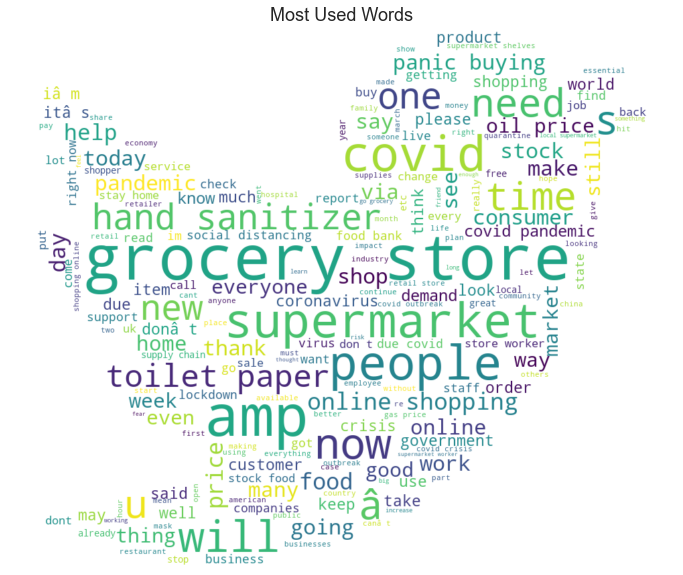

In [19]:
covidTweets['cloud_text'] = covidTweets['tweet_text'].str.lower()
covidTweets['cloud_text'] = covidTweets['cloud_text'].apply(lambda x:remove_tag(str(x)))
covidTweets['cloud_text'] = covidTweets['cloud_text'].apply(lambda x:remove_mention(str(x)))
covidTweets['cloud_text'] = covidTweets['cloud_text'].apply(lambda x:remove_hash(str(x)))
covidTweets['cloud_text'] = covidTweets['cloud_text'].apply(lambda x:remove_newline(x))
covidTweets['cloud_text'] = covidTweets['cloud_text'].apply(lambda x:remove_url(x))
covidTweets['cloud_text'] = covidTweets['cloud_text'].apply(lambda x:remove_number(x))
covidTweets['cloud_text'] = covidTweets['cloud_text'].apply(lambda x:remove_punct(x))
covidTweets['cloud_text'] = covidTweets['cloud_text'].apply(lambda x:remove_stopwords(x))
covidTweets['cloud_text'] = covidTweets['cloud_text'].apply(lambda x:text_strip(x))

wordcloud_freq = WordCloud(background_color='white', mask = twitter_image,
                        width=600,height=400).generate(" ".join(covidTweets['cloud_text']))

# plot the WordCloud image     
fig, (ax) = plt.subplots(1,1,figsize=[12, 12])
ax.imshow(wordcloud_freq, interpolation='bilinear')
ax.axis('off')
ax.set_title('Most Used Words', fontsize = 18)
plt.show()

### From above word cloud, most frequently used words in the tweets are grocery store, hand sanitizer, supermarket, covid, people, etc.

### <span style = "color : indigo" > 7) Positive Vs Negative Sentiment words

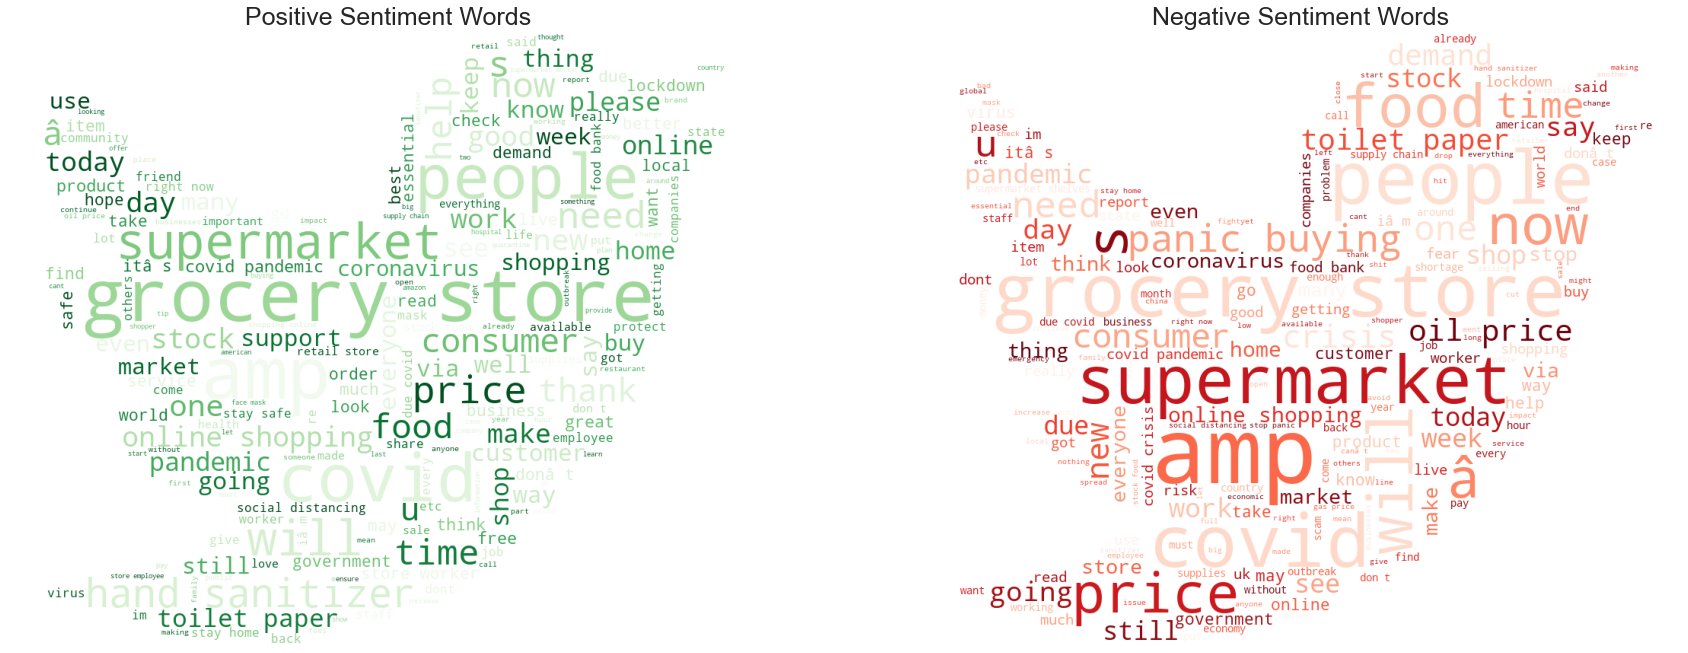

In [20]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize = [30, 15])
wordcloud_pos = WordCloud( background_color ='white',mask = twitter_image, colormap="Greens",
                        width=600,
                        height=400).generate(" ".join(covidTweets[covidTweets['Sentiment'] == "positive"]['cloud_text']))
ax2.imshow(wordcloud_pos)
ax2.axis('off')
ax2.set_title('Positive Sentiment Words',fontsize = 25);

wordcloud_neg = WordCloud( background_color ='white',mask = twitter_image,colormap="Reds",
                        width=600,
                        height=400).generate(" ".join(covidTweets[covidTweets['Sentiment'] == "negative"]['cloud_text']))
ax3.imshow(wordcloud_neg)
ax3.axis('off')
ax3.set_title('Negative Sentiment Words', fontsize = 25);

### From the word clouds above, we can say that
<br> 1) most frequent words used in positive sentiment tweets are grocery store, supermarket, price, food, price etc. <br> 2) most frequent words used in negative sentiment tweets are panic buying, supermarket, covid, oil price, food, market, etc.


### <span style = "color : indigo" > 9) N-grams

In [21]:
def ngram_df(corpus, nrange, n=None):
    vec = CountVectorizer(stop_words = 'english', ngram_range=nrange).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    df = pd.DataFrame(total_list,columns=['text','count'])
    return df

In [22]:
unigram_df = ngram_df(covidTweets['cloud_text'],(1,1),20)
bigram_df = ngram_df(covidTweets['cloud_text'],(2,2),20)
trigram_df = ngram_df(covidTweets['cloud_text'],(3,3),20)

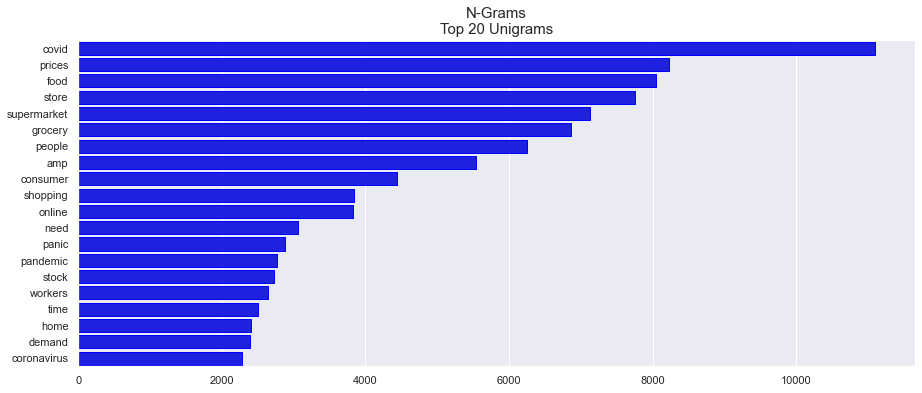

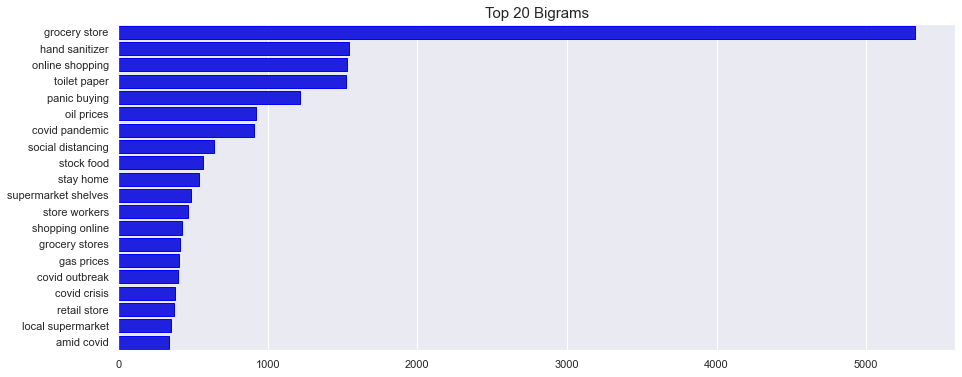

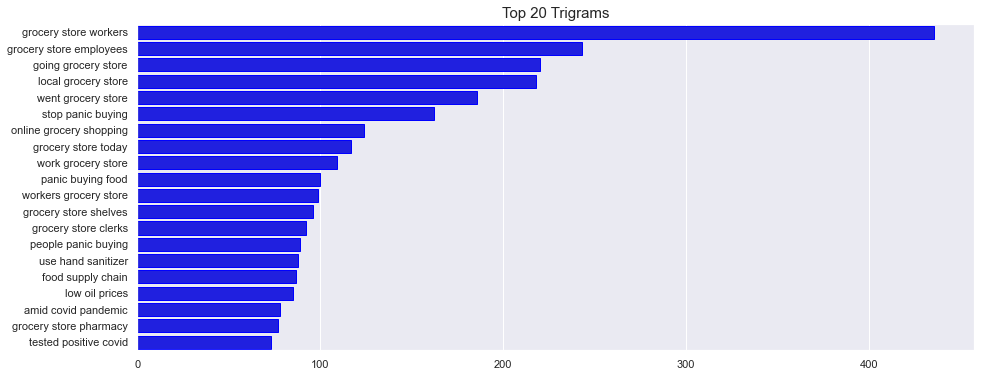

In [23]:
sns.set(rc={'figure.figsize':(15,6)})
sns_uni = sns.barplot(x = unigram_df['count'][::-1], 
                      y = unigram_df['text'][::-1], 
                      color = 'blue',
                      order = unigram_df.sort_values('count',ascending = False).text, 
                      edgecolor = 'blue')

sns_uni.set(xlabel = None)
sns_uni.set(ylabel = None)
plt.title("N-Grams\nTop 20 Unigrams", fontsize = 15)

plt.show()

sns.set(rc={'figure.figsize':(15,6)})
sns_bi = sns.barplot(x = bigram_df['count'][::-1],
                      y = bigram_df['text'][::-1], 
                      color = 'blue',
                      order = bigram_df.sort_values('count',ascending = False).text, 
                      edgecolor = 'blue')

sns_bi.set(xlabel = None)
sns_bi.set(ylabel = None)
plt.title("Top 20 Bigrams", fontsize = 15)
plt.show()

sns_tri = sns.barplot(x = trigram_df['count'][::-1], 
                      y = trigram_df['text'][::-1], 
                      color = 'blue',
                      order = trigram_df.sort_values('count',ascending = False).text, 
                      edgecolor = 'blue')

sns_tri.set(xlabel = None)
sns_tri.set(ylabel = None)
plt.title("Top 20 Trigrams", fontsize = 15)
plt.show()

### From the plot above, the most used unigram, bigram and trigram are:
 1) single sequence (unigram) - covid <br>
 2) two-word sequence (Bigram) - grocery store <br>
 3) three-word sequence (Trigram) - grocery store workers

### <span style = "color : indigo" > 9) Mentions

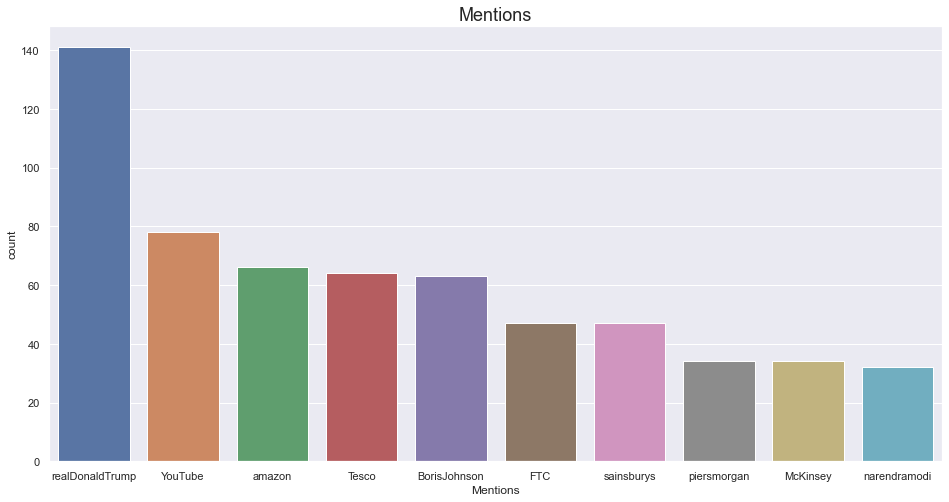

In [24]:
def mentions(text):
    line = re.findall(r'(?<=@)\w+',text)
    return " ".join(line)

mentions = covidTweets['tweet_text'].apply(lambda x:mentions(x))
mentions = mentions.value_counts()[:][1:11]
mentions = mentions.to_frame().reset_index().rename(columns={'index':'Mentions','tweet_text':'count'})
sns.set(rc={'figure.figsize':(16,8)})
sns.barplot(x="Mentions",y="count", data = mentions)
plt.title("Mentions", fontsize = 18)
plt.show()

#### Bar chart above shows the top mentions/tags on covid tweets, with realDonaldTrump tagged the most.

##  <span style = 'color:blue'> Data Pre-Processing
    
Remove tags, twitter handles, hashtags, new lines, URLs, numbers, punctuations, stopwords from tweets.
Lower casing the tweets and text stemming

In [25]:
def stemming(string):
    ps = nltk.porter.PorterStemmer()
    stem = ' '.join([ps.stem(word) for word in string.split()])
    return stem

covidTweets['tweet_text'] = covidTweets['tweet_text'].str.lower()
covidTweets['tweet_text'] = covidTweets['tweet_text'].apply(lambda x:remove_tag(str(x)))
covidTweets['tweet_text'] = covidTweets['tweet_text'].apply(lambda x:remove_mention(str(x)))
covidTweets['tweet_text'] = covidTweets['tweet_text'].apply(lambda x:remove_hash(str(x)))
covidTweets['tweet_text'] = covidTweets['tweet_text'].apply(lambda x:remove_newline(x))
covidTweets['tweet_text'] = covidTweets['tweet_text'].apply(lambda x:remove_url(x))
covidTweets['tweet_text'] = covidTweets['tweet_text'].apply(lambda x:remove_number(x))
covidTweets['tweet_text'] = covidTweets['tweet_text'].apply(lambda x:remove_punct(x))
covidTweets['tweet_text'] = covidTweets['tweet_text'].apply(lambda x:remove_stopwords(x))
covidTweets['tweet_text'] = covidTweets['tweet_text'].apply(lambda x:stemming(x))
covidTweets['tweet_text'] = covidTweets['tweet_text'].apply(lambda x:text_strip(x))

##  <span style = 'color:blue'> Modelling

In [26]:
# Split dataset into input and output arrays
X = covidTweets['tweet_text']
y = covidTweets['Sentiment']

In [27]:
# Divide test and testing sets
tweet_train, tweet_test, sentiment_train, sentiment_test = train_test_split(X, y, test_size=0.2)

In [28]:
# Vectorize the tweets
vectorizer = TfidfVectorizer(lowercase=True,
                             tokenizer = casual_tokenize,
                             min_df = 0.0004,
                             max_df=0.65)

cv_tweet_train = vectorizer.fit_transform(tweet_train).toarray()
cv_tweet_test = vectorizer.transform(tweet_test).toarray()

In [29]:
# Labeling the output (sentiment)
le = preprocessing.LabelEncoder()

# Transformed sentiment data
labeled_sentiment_train = le.fit_transform(sentiment_train)
labeled_sentiment_test = le.fit_transform(sentiment_test)

##  <span style = 'color:blue'> Baseline Models

### <span style = "color : indigo" > 1) Multinomial Naive Bayes

In [30]:
# Create model and fit the train data
nb = MultinomialNB()
nb.fit(cv_tweet_train, labeled_sentiment_train)

MultinomialNB()

In [31]:
# predict output on test data
pred_nb = nb.predict(cv_tweet_test)
print("Predicted Sentiment(NB):", pred_nb)

Predicted Sentiment(NB): [0 0 2 ... 2 0 0]


In [32]:
# accuracy of MultinomialNB model
accuracy_nb = accuracy_score(labeled_sentiment_test, pred_nb)
print("MultinomialNB Accuracy:: %0.3f %%" %(accuracy_nb*100))

MultinomialNB Accuracy:: 67.445 %


In [33]:
# classification report for MultinomialNB model
nb_report = classification_report(labeled_sentiment_test, pred_nb, target_names=le.classes_)

print("Classification report for Naive Bayes Model")
print(nb_report)

Classification report for Naive Bayes Model
              precision    recall  f1-score   support

    negative       0.70      0.73      0.72      3362
     neutral       0.74      0.14      0.24      1671
    positive       0.65      0.85      0.74      3958

    accuracy                           0.67      8991
   macro avg       0.70      0.58      0.56      8991
weighted avg       0.69      0.67      0.64      8991



### <span style = "color : indigo" > 2) LinearDiscriminantAnalysis

In [34]:
# Create model and fit the train data
lda = LinearDiscriminantAnalysis()
lda.fit(cv_tweet_train, labeled_sentiment_train)

LinearDiscriminantAnalysis()

In [35]:
# predict output on test data
pred_lda = lda.predict(cv_tweet_test)
print("Predicted Sentiment(LDA):", pred_lda)

Predicted Sentiment(LDA): [0 1 0 ... 0 0 2]


In [36]:
# accuracy of LDA model
accuracy_lda = accuracy_score(labeled_sentiment_test, pred_lda)
print("Linear Discriminant Analysis Accuracy: %0.3f %%" %(accuracy_lda*100))

Linear Discriminant Analysis Accuracy: 77.711 %


In [37]:
# classification report for Linear Discriminant Analysis model
lda_report = classification_report(labeled_sentiment_test, pred_lda, target_names=le.classes_)
print("Classification report for LDA Model")
print(lda_report)

Classification report for LDA Model
              precision    recall  f1-score   support

    negative       0.81      0.77      0.79      3362
     neutral       0.65      0.70      0.68      1671
    positive       0.81      0.81      0.81      3958

    accuracy                           0.78      8991
   macro avg       0.76      0.76      0.76      8991
weighted avg       0.78      0.78      0.78      8991



##  <span style = 'color:blue'> Compare Unigram and Bigram - TDIF

### <span style = "color : indigo" > Logistic Regression - Unigram (TDIF)

In [38]:
scores_TDIF = []
model_TDIF = []
# Create model and cross validate
lr = LogisticRegression(solver='liblinear')
kf = KFold(n_splits=10,random_state=7, shuffle=True)
score = cross_val_score(lr, cv_tweet_train, labeled_sentiment_train, cv = kf, scoring='accuracy')
model_TDIF.append("LR-Uni (TDIF)")
scores_TDIF.append(score)
print('Mean Accuracy(LR-Uni-TDIF): %0.3f %%' % (score.mean()*100))   

Mean Accuracy(LR-Uni-TDIF): 79.018 %


In [73]:
lr.fit(cv_tweet_train, labeled_sentiment_train)

# predict output on test data
pred_lr = lr.predict(cv_tweet_test)

# accuracy of Logistic Regression model
accuracy_lr = accuracy_score(labeled_sentiment_test, pred_lr)
print("Logistic Regression - Unigram(TDIF)")
print("Accuracy on test data: %0.3f %%\n" %(accuracy_lr * 100))

# classification report for Logistic Regression model
lr_report = classification_report(labeled_sentiment_test, pred_lr, target_names=le.classes_)
print("Classification report")
print(lr_report)

Logistic Regression - Unigram(TDIF)
Accuracy on test data: 79.124 %

Classification report
              precision    recall  f1-score   support

    negative       0.80      0.81      0.81      3362
     neutral       0.76      0.60      0.67      1671
    positive       0.79      0.85      0.82      3958

    accuracy                           0.79      8991
   macro avg       0.79      0.76      0.77      8991
weighted avg       0.79      0.79      0.79      8991



### <span style = "color : indigo" > LinearSVC - Unigram (TDIF)

In [40]:
# Create model and cross validate
svm =  LinearSVC(dual=False)
kf = KFold(n_splits=10,random_state=7, shuffle=True)
score = cross_val_score(svm, cv_tweet_train, labeled_sentiment_train, cv = kf, scoring='accuracy')
model_TDIF.append("SVM-Uni (TDIF)")
scores_TDIF.append(score)
print('Mean Classification Accuracy(SVM-Uni-TDIF): %0.3f %%' % (score.mean()*100))   

Mean Classification Accuracy(SVM-Uni-TDIF): 80.856 %


In [41]:
# fit model and predict output on test data
svm.fit(cv_tweet_train, labeled_sentiment_train)
pred_svm = svm.predict(cv_tweet_test)

# accuracy of SVM model
accuracy_svm = accuracy_score(labeled_sentiment_test, pred_svm)
print("LinearSVC - Unigram(TDIF)")
print("Accuracy on test data: %0.3f %%\n" %(accuracy_svm*100))

# classification report for SVM model
svm_report = classification_report(labeled_sentiment_test, pred_svm)
print("Classification report")
print(svm_report)

LinearSVC - Unigram(TDIF)
Accuracy on test data: 80.681 %

Classification report
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3362
           1       0.73      0.69      0.71      1671
           2       0.83      0.85      0.84      3958

    accuracy                           0.81      8991
   macro avg       0.79      0.78      0.79      8991
weighted avg       0.81      0.81      0.81      8991



### <span style = "color : indigo" > Logistic Regression - Unigram and Bigram (TDIF)

In [42]:
# Vectorize the tweets unigram and bigram
vectorizer_unibi = TfidfVectorizer(lowercase=True,
                             tokenizer = casual_tokenize,
                             min_df = 0.0004,
                             max_df=0.65,
                             ngram_range = (1,2))

unibi_tweet_train = vectorizer_unibi.fit_transform(tweet_train).toarray()
unibi_tweet_test = vectorizer_unibi.transform(tweet_test).toarray()

In [43]:
# Create model and cross validate
lr = LogisticRegression(solver='liblinear')
kf = KFold(n_splits=10,random_state=7, shuffle=True)
score = cross_val_score(lr, unibi_tweet_train, labeled_sentiment_train, cv = kf, scoring='accuracy')
model_TDIF.append("LR-UniBi (TDIF)")
scores_TDIF.append(score)
print('Mean Classification Accuracy(LR-UniBi-TDIF): %0.3f %%' % (score.mean()*100))   

Mean Classification Accuracy(LR-UniBi-TDIF): 78.131 %


In [44]:
# fit model and predict output on test data
lr.fit(unibi_tweet_train, labeled_sentiment_train)
pred_lr_unibi = lr.predict(unibi_tweet_test)

# accuracy of Logistic Regression model
accuracy_lr_unibi = accuracy_score(labeled_sentiment_test, pred_lr_unibi)
print("Logistic Regression - Unigram & Bigram(TDIF)")
print("Accuracy on test data: %0.3f %% \n" %(accuracy_lr_unibi*100))

# classification report for SVM model
lr_report = classification_report(labeled_sentiment_test, pred_lr_unibi)
print("Classification report")
print(lr_report)

Logistic Regression - Unigram & Bigram(TDIF)
Accuracy on test data: 78.612 % 

Classification report
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3362
           1       0.76      0.58      0.66      1671
           2       0.79      0.85      0.82      3958

    accuracy                           0.79      8991
   macro avg       0.78      0.75      0.76      8991
weighted avg       0.78      0.79      0.78      8991



### <span style = "color : indigo" > LinearSVC - Unigram and Bigram - TDIF

In [45]:
# Create model and cross validate
svm =  LinearSVC(dual=False)
kf = KFold(n_splits=10,random_state=7, shuffle=True)
score = cross_val_score(svm, unibi_tweet_train, labeled_sentiment_train, cv = kf, scoring='accuracy')
model_TDIF.append("SVM-UniBi (TDIF)")
scores_TDIF.append(score)
print('Mean Classification Accuracy(SVM-UniBi-TDIF): %0.3f %%' % (score.mean()*100))   

Mean Classification Accuracy(SVM-UniBi-TDIF): 79.432 %


In [46]:
# fit model and predict output on test data
svm.fit(unibi_tweet_train, labeled_sentiment_train)
pred_svm_unibi = svm.predict(unibi_tweet_test)

# accuracy of SVM model
accuracy_svm_unibi = accuracy_score(labeled_sentiment_test, pred_svm_unibi)
print("LinearSVC - Unigram & Bigram (TDIF)")
print("Accuracy on test data: %0.3f %% \n" %(accuracy_svm_unibi*100))

# classification report for SVM model
svm_report = classification_report(labeled_sentiment_test, pred_svm)
print("Classification report")
print(svm_report)

LinearSVC - Unigram & Bigram (TDIF)
Accuracy on test data: 79.802 % 

Classification report
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3362
           1       0.73      0.69      0.71      1671
           2       0.83      0.85      0.84      3958

    accuracy                           0.81      8991
   macro avg       0.79      0.78      0.79      8991
weighted avg       0.81      0.81      0.81      8991



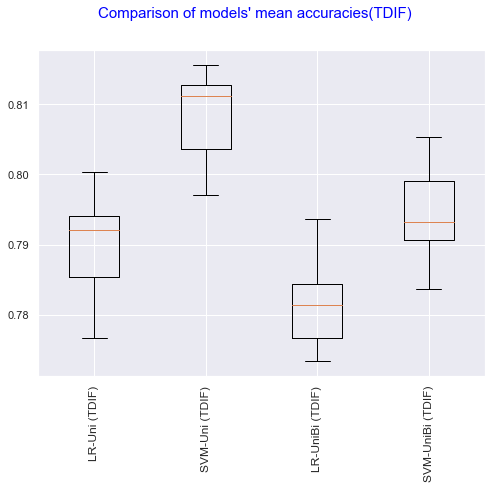

In [47]:
# plot the mean accuracies for TDIF
sns.set(rc={'figure.figsize':(8,6)})
fig, ax = plt.subplots()
fig.suptitle("Comparison of models' mean accuracies(TDIF)", color = 'blue',fontsize = 15)
ax.boxplot(scores_TDIF)
xtickNames = plt.setp(ax, xticklabels=model_TDIF)
plt.setp(xtickNames, rotation=90, fontsize=12)
plt.show()

### From the plot above, the mean accuracy is higher for  of SVM model with Unigram-TDIF

##  <span style = 'color:blue'> Compare Unigram and Bigram - Bag of Words

### <span style = "color : indigo" > Logistic Regression - Unigram - BOW

In [48]:
#Count vectorizer for bag of words
BoW=CountVectorizer()

#transformed train reviews
BoW_tweet_train=BoW.fit_transform(tweet_train)
#transformed test reviews
BoW_tweet_test=BoW.transform(tweet_test)

In [49]:
#Logistic Regression Bag of Words
scores_BOW = []
model_BOW = []
lr = LogisticRegression(solver='liblinear')
kf = KFold(n_splits=10,random_state=7, shuffle=True)
score = cross_val_score(lr, BoW_tweet_train, labeled_sentiment_train, cv = kf, scoring='accuracy')
model_BOW.append("LR-Uni (BOW)")
scores_BOW.append(score)
print('Mean Classification Accuracy(LR-Uni-BOW): %0.3f %%' % (score.mean()*100))   

Mean Classification Accuracy(LR-Uni-BOW): 81.092 %


In [50]:
#fitting the model for bag of words
lr.fit(BoW_tweet_train, labeled_sentiment_train)

# predict output on test data
pred_lr = lr.predict(BoW_tweet_test)

# accuracy of Logistic Regression model
accuracy_lr = accuracy_score(labeled_sentiment_test, pred_lr)
print("Logistic Regression - Unigram (BOW)")
print("Accuracy on test data: %0.4f %%\n" %(accuracy_lr * 100))

# classification report for Logistic Regression model
lr_report = classification_report(labeled_sentiment_test, pred_lr, target_names=le.classes_)
print("Classification report")
print(lr_report)

Logistic Regression - Unigram (BOW)
Accuracy on test data: 80.9365 %

Classification report
              precision    recall  f1-score   support

    negative       0.83      0.82      0.82      3362
     neutral       0.72      0.71      0.71      1671
    positive       0.83      0.84      0.84      3958

    accuracy                           0.81      8991
   macro avg       0.79      0.79      0.79      8991
weighted avg       0.81      0.81      0.81      8991



### <span style = "color : indigo" > LinearSVC - Unigram - BOW

In [51]:
#LinearSVC Bag of Words
svm = LinearSVC(dual=False)
kf = KFold(n_splits=10,random_state=7, shuffle=True)
score = cross_val_score(svm, BoW_tweet_train, labeled_sentiment_train, cv = kf, scoring='accuracy')
model_BOW.append("SVM-Uni (BOW)")
scores_BOW.append(score)
print('Mean Classification Accuracy(SVM-Uni-BOW): %0.3f %%' % (score.mean()*100))   

Mean Classification Accuracy(SVM-Uni-BOW): 78.606 %


In [52]:
#fitting the SVM for bag of words
svm.fit(BoW_tweet_train,labeled_sentiment_train.ravel())

#Accuracy
svm_bow_predict = svm.predict(BoW_tweet_test)

#Accuracy score for SVM bag of words
svm_bow_score=accuracy_score(labeled_sentiment_test,svm_bow_predict)
print("LinearSVC - Unigram (BOW)")
print("Accuracy on test data: %0.4f %%\n" %(svm_bow_score*100))

#Classification report for bag of words 
svm_bow_report=classification_report(labeled_sentiment_test,svm_bow_predict,target_names=le.classes_)
print("Classification report")
print(svm_bow_report)

LinearSVC - Unigram (BOW)
Accuracy on test data: 78.3673 %

Classification report
              precision    recall  f1-score   support

    negative       0.81      0.79      0.80      3362
     neutral       0.65      0.69      0.67      1671
    positive       0.82      0.82      0.82      3958

    accuracy                           0.78      8991
   macro avg       0.76      0.77      0.76      8991
weighted avg       0.79      0.78      0.78      8991



### <span style = "color : indigo" > Logistic Regression - Unigram and Bigram - BOW

In [53]:
BoW_bi=CountVectorizer(ngram_range=(1,2))
#transformed train reviews
BoW_bi_tweet_train=BoW_bi.fit_transform(tweet_train)
#transformed test reviews
BoW_bi_tweet_test=BoW_bi.transform(tweet_test)

In [54]:
#Logistic Regression Bag of Words
lr = LogisticRegression(solver='liblinear')
kf = KFold(n_splits=10,random_state=7, shuffle=True)
score = cross_val_score(lr, BoW_bi_tweet_train, labeled_sentiment_train, cv = kf, scoring='accuracy')
model_BOW.append("LR-UniBi (BOW)")
scores_BOW.append(score)
print('Mean Classification Accuracy(LR-UniBi-BOW): %0.3f %%' % (score.mean()*100))   

Mean Classification Accuracy(LR-UniBi-BOW): 80.422 %


In [55]:
#fitting the model for bag of words
lr.fit(BoW_bi_tweet_train, labeled_sentiment_train)

# predict output on test data
pred_lr = lr.predict(BoW_bi_tweet_test)

# accuracy of Logistic Regression model
print("Logistic Regression - Unigram & Bigram (BOW)")
accuracy_lr = accuracy_score(labeled_sentiment_test, pred_lr)
print("Accuracy on test data: %0.4f %%\n" %(accuracy_lr * 100))

# classification report for Logistic Regression model
lr_report = classification_report(labeled_sentiment_test, pred_lr, target_names=le.classes_)
print("Classification report")
print(lr_report)

Logistic Regression - Unigram & Bigram (BOW)
Accuracy on test data: 80.4249 %

Classification report
              precision    recall  f1-score   support

    negative       0.82      0.81      0.82      3362
     neutral       0.71      0.72      0.71      1671
    positive       0.83      0.83      0.83      3958

    accuracy                           0.80      8991
   macro avg       0.79      0.79      0.79      8991
weighted avg       0.80      0.80      0.80      8991



### <span style = "color : indigo" > LinearSVC - Unigram and Bigram - BOW

In [57]:
#LinearSVC Bag of Words
svm = LinearSVC(dual=False)
kf = KFold(n_splits=10,random_state=7, shuffle=True)
score = cross_val_score(svm, BoW_bi_tweet_train, labeled_sentiment_train, cv = kf, scoring='accuracy')
model_BOW.append("SVM-UniBi (BOW)")
scores_BOW.append(score)
print('Mean Classification Accuracy(SVM-UniBi-BOW): %0.3f %%' % (score.mean()*100))   

Mean Classification Accuracy(SVM-UniBi-BOW): 79.833 %


In [58]:
#fitting the SVM for bag of words
svm.fit(BoW_bi_tweet_train,labeled_sentiment_train.ravel())

# predict 
svm_bow_predict = svm.predict(BoW_bi_tweet_test)

#Accuracy score for SVM bag of words
svm_bow_score=accuracy_score(labeled_sentiment_test,svm_bow_predict)
print("LinearSVC - Unigram & Bigram (BOW)")
print("Accuracy on test data: %0.4f %%\n" %(svm_bow_score*100))

#Classification report for bag of words 
svm_bow_report=classification_report(labeled_sentiment_test,svm_bow_predict,target_names=le.classes_)
print("Classification report")
print(svm_bow_report)

LinearSVC - Unigram & Bigram (BOW)
Accuracy on test data: 79.7575 %

Classification report
              precision    recall  f1-score   support

    negative       0.83      0.79      0.81      3362
     neutral       0.67      0.75      0.71      1671
    positive       0.83      0.82      0.83      3958

    accuracy                           0.80      8991
   macro avg       0.78      0.79      0.78      8991
weighted avg       0.80      0.80      0.80      8991



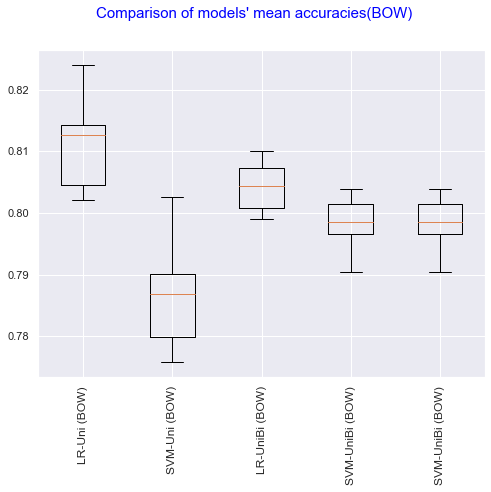

In [59]:
# plot the mean accuracies for Bag of words
sns.set(rc={'figure.figsize':(8,6)})
fig, ax = plt.subplots()
fig.suptitle("Comparison of models' mean accuracies(BOW)", color = 'blue',fontsize = 15)
ax.boxplot(scores_BOW)
xtickNames = plt.setp(ax, xticklabels=model_BOW)
plt.setp(xtickNames, rotation=90, fontsize=12)
plt.show()

### From the above plot, the mean accuracy is high for logistic regression using Unigram - Bag of Words

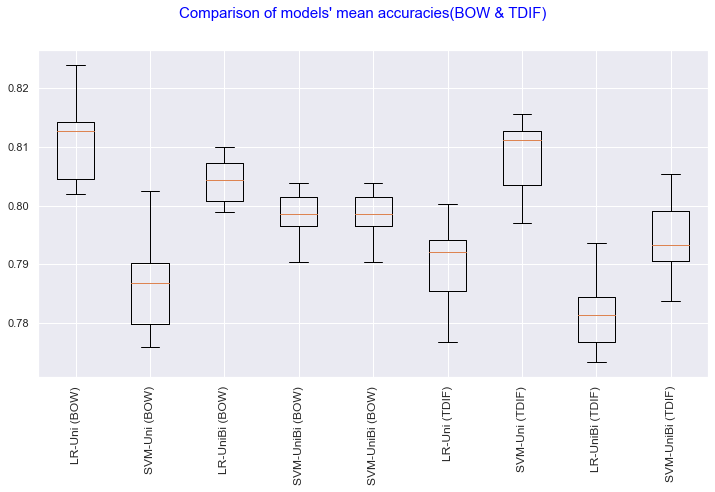

In [60]:
# plot mean accuracies of both TDIF and BOW
models = model_BOW + model_TDIF
scores = scores_BOW + scores_TDIF
sns.set(rc={'figure.figsize':(12,6)})
fig, ax = plt.subplots()
fig.suptitle("Comparison of models' mean accuracies(BOW & TDIF)", color = 'blue',fontsize = 15)
ax.boxplot(scores)
xtickNames = plt.setp(ax, xticklabels=models)
plt.setp(xtickNames, rotation=90, fontsize=12)
plt.show()

### From the results above, the mean accuracy is higher for logistic regression model with Unigram BOW. 

##  <span style = 'color:blue'> LogisticRegression with "saga" solver and penalty "elasticnet"

In [58]:
# Create model and fit the train data
lr_saga = LogisticRegression(solver="saga", 
                             penalty = 'elasticnet', 
                             l1_ratio=0.7, 
                             n_jobs=-1, 
                             max_iter = 1000)
lr_saga.fit(cv_tweet_train, labeled_sentiment_train)

LogisticRegression(l1_ratio=0.7, max_iter=1000, n_jobs=-1, penalty='elasticnet',
                   solver='saga')

In [59]:
# predict output on test data
pred_lr_saga = lr_saga.predict(cv_tweet_test)

# accuracy of logistic regression model
accuracy_lr_saga = accuracy_score(labeled_sentiment_test, pred_lr_saga)
print("Logistic Regression Accuracy(saga,elasticnet)")
print("Accuracy on test data: %0.4f %%\n" %(accuracy_lr_saga*100))

# classification report for Logistic Regression model
lr_saga_report = classification_report(labeled_sentiment_test, pred_lr_saga)
print("Classification report")
print(lr_saga_report)

Logistic Regression Accuracy(saga,elasticnet)
Accuracy on test data: 81.6261 %

Classification report
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      3448
           1       0.73      0.73      0.73      1632
           2       0.83      0.85      0.84      3911

    accuracy                           0.82      8991
   macro avg       0.80      0.80      0.80      8991
weighted avg       0.82      0.82      0.82      8991



##  <span style = 'color:blue'> SGDClassifier with grid search

In [61]:
# Define model and grid search parameters
model = SGDClassifier()
loss = ['modified_huber', 'squared_hinge', 'perceptron']
param_grid = dict(loss = loss)
kf = KFold(n_splits=5,random_state=7, shuffle=True)

# perform gridsearch
grid = GridSearchCV(estimator = model, scoring='accuracy', param_grid = param_grid, n_jobs = -1, cv = kf)
grid_result = grid.fit(cv_tweet_train, labeled_sentiment_train)

In [62]:
# print accuracy for all the parameter in gridsearch
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.801190 (0.004152) with: {'loss': 'modified_huber'}
0.741325 (0.003231) with: {'loss': 'squared_hinge'}
0.756674 (0.010670) with: {'loss': 'perceptron'}


In [63]:
# print best value for parameter 'loss'
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.801190 using {'loss': 'modified_huber'}


From results above, the loss parameter with highest accuracy is "modified_huber". Hence we will use that in SGD model

In [64]:
sgd = SGDClassifier(loss='modified_huber', penalty='l1', random_state=42)
sgd.fit(cv_tweet_train, labeled_sentiment_train)

SGDClassifier(loss='modified_huber', penalty='l1', random_state=42)

In [65]:
# predict output on test data
pred_sgd = sgd.predict(cv_tweet_test)
print("Predicted Sentiment(SGD):", pred_sgd)

Predicted Sentiment(SGD): [0 1 0 ... 0 0 2]


In [66]:
# accuracy of SGDClassifier model
accuracy_sgd = accuracy_score(labeled_sentiment_test, pred_sgd)
print("SGDClassifier Accuracy: %0.3f %%" %(accuracy_sgd*100))

SGDClassifier Accuracy: 82.093 %


In [67]:
# classification report for SGDClassifier
sgd_report = classification_report(labeled_sentiment_test, pred_sgd)
print("Classification_report for SGDClassifier Model")
print(sgd_report)

Classification_report for SGDClassifier Model
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      3362
           1       0.73      0.76      0.74      1671
           2       0.84      0.85      0.85      3958

    accuracy                           0.82      8991
   macro avg       0.81      0.81      0.81      8991
weighted avg       0.82      0.82      0.82      8991



##  <span style = 'color:blue'> Ensemble using VotingClassifier

In [69]:
models = []
models.append(('logistic', LogisticRegression(solver="saga", penalty = 'elasticnet', l1_ratio=0.7, n_jobs=-1, max_iter = 1000)))
models.append(('SGD', SGDClassifier(loss='modified_huber', penalty='l1', random_state=42)))
models.append(('SVM', LinearSVC(dual=False)))          

In [70]:
# Create voting classifier and cross validate
voting_model = VotingClassifier(models)
kf = KFold(n_splits=10,random_state=7, shuffle=True)
results = cross_val_score(voting_model, cv_tweet_train, labeled_sentiment_train, cv=kf)
print('Mean Classification Accuracy: %0.3f %%' % (results.mean()*100))

Mean Classification Accuracy: 82.316 %


In [72]:
# fit and predict output on test data
voting_model.fit(cv_tweet_train, labeled_sentiment_train)
pred_vote = voting_model.predict(cv_tweet_test)

# accuracy on test data
accuracy_vote = accuracy_score(labeled_sentiment_test, pred_vote)
print("VotingClassifier Accuracy: %0.3f %%\n" %(accuracy_vote*100))

# classification report for voting classifier
vote_report = classification_report(labeled_sentiment_test, pred_vote)
print("Classification report for VotingClassifier Model")
print(vote_report)

VotingClassifier Accuracy: 82.438 %

Classification report for VotingClassifier Model
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      3362
           1       0.76      0.73      0.74      1671
           2       0.84      0.86      0.85      3958

    accuracy                           0.82      8991
   macro avg       0.81      0.81      0.81      8991
weighted avg       0.82      0.82      0.82      8991



##  <span style = 'color:blue'> Overall Accuracy Plot

In [75]:
scores_Ensemble = []
model_Ensemble = []
model_Ensemble.append("Ensemble (TF-IDF)")
scores_Ensemble.append(results)

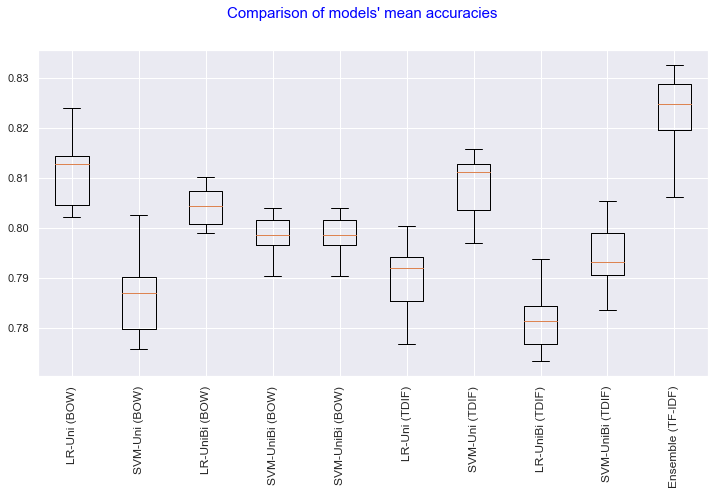

In [76]:
# plot mean accuracies of both TDIF and BOW
models = model_BOW + model_TDIF + model_Ensemble
scores = scores_BOW + scores_TDIF + scores_Ensemble
sns.set(rc={'figure.figsize':(12,6)})
fig, ax = plt.subplots()
fig.suptitle("Comparison of models' mean accuracies", color = 'blue',fontsize = 15)
ax.boxplot(scores)
xtickNames = plt.setp(ax, xticklabels=models)
plt.setp(xtickNames, rotation=90, fontsize=12)
plt.show()

##  <span style = 'color:blue'> Deep Learning Model - Bag Of Words (BOW) with Keras

In [70]:
# tokenize input tweet text
max_words = 1000
tokenize = text.Tokenizer(num_words = max_words, char_level=False)
tokenize.fit_on_texts(tweet_train)

X_train = tokenize.texts_to_matrix(tweet_train)
X_test = tokenize.texts_to_matrix(tweet_test)

# Label target sentiment class and convert to matrix
encoder = preprocessing.LabelEncoder()
encoder.fit(sentiment_train)
y_train = encoder.transform(sentiment_train)
y_test = encoder.transform(sentiment_test)
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [71]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [72]:
# Define inputs to fit model
batch_size = 32
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.8, decay=decay)

In [73]:
# compile model
model.compile(loss='categorical_crossentropy',
              #optimizer='adam', 
              optimizer=sgd, 
              metrics=['accuracy'])

In [74]:
# fit model on train data
model_fit = model.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_test, y_test),
                    validation_split = 0.2)

Epoch 1/25
900/900 [==============================] - 4s 4ms/step - loss: 0.9797 - accuracy: 0.4982 - val_loss: 0.8480 - val_accuracy: 0.6111
Epoch 2/25
900/900 [==============================] - 2s 2ms/step - loss: 0.8308 - accuracy: 0.6291 - val_loss: 0.7746 - val_accuracy: 0.6686
Epoch 3/25
900/900 [==============================] - 2s 2ms/step - loss: 0.7664 - accuracy: 0.6730 - val_loss: 0.7367 - val_accuracy: 0.6894
Epoch 4/25
900/900 [==============================] - 2s 2ms/step - loss: 0.7185 - accuracy: 0.7021 - val_loss: 0.7149 - val_accuracy: 0.7049
Epoch 5/25
900/900 [==============================] - 2s 2ms/step - loss: 0.6982 - accuracy: 0.7119 - val_loss: 0.7016 - val_accuracy: 0.7124
Epoch 6/25
900/900 [==============================] - 2s 2ms/step - loss: 0.6820 - accuracy: 0.7224 - val_loss: 0.6915 - val_accuracy: 0.7142
Epoch 7/25
900/900 [==============================] - 2s 2ms/step - loss: 0.6626 - accuracy: 0.7297 - val_loss: 0.6846 - val_accuracy: 0.7199
Epoch 

In [75]:
# Evaluate model on test data and print accuracy
scores = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=0)
print("Accuracy: %.4f %%" % (scores[1]*100))

Accuracy: 73.8183 %


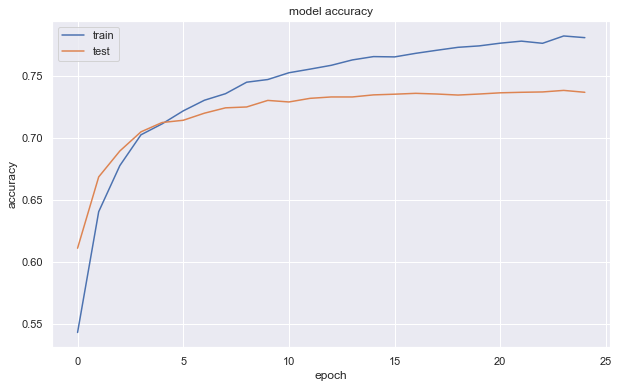

In [76]:
# plot  accuracy
sns.set(rc={'figure.figsize':(10,6)})
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

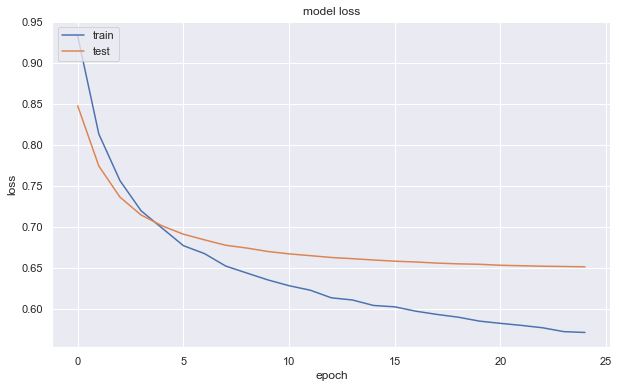

In [77]:
# plot model loss
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()